# Time Series Forecasting with XGBoost
### Predicting energy consumption
We will use XGBoost algorithm as it is considered one of the best for tabular data and even time series problems like this. We are using an hourly energy consumption dataset from Kaggle.

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# Importing the dataset
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Time-Series-projects/data/raw/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
# With pandas is very common to set our index to be a datetime object
df = df.set_index('Datetime') # Setting the index to be the datetime
df.index = pd.to_datetime(df.index) # Converting the index to a datetime index
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


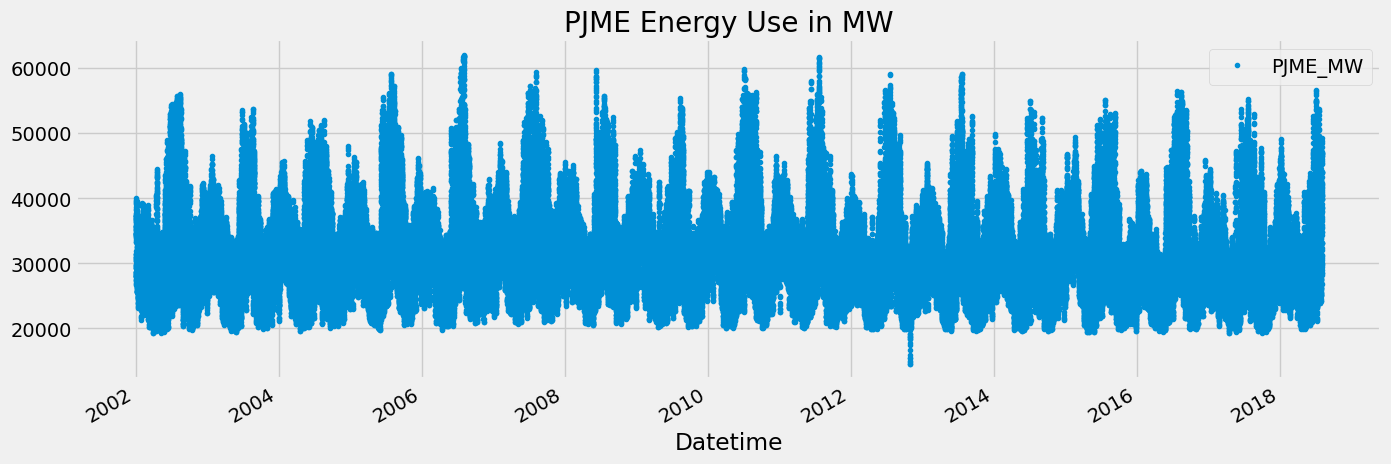

In [122]:
# Let's visualize the data
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0], 
        title='PJME Energy Use in MW')
plt.show()

## Train / Test Split
For this case we are going to split the data on the date January 2015 and have everything prior to January 2015 be our training data and keep our test data as the following dates. We can do that by finding where it's less than January 1st 2015:

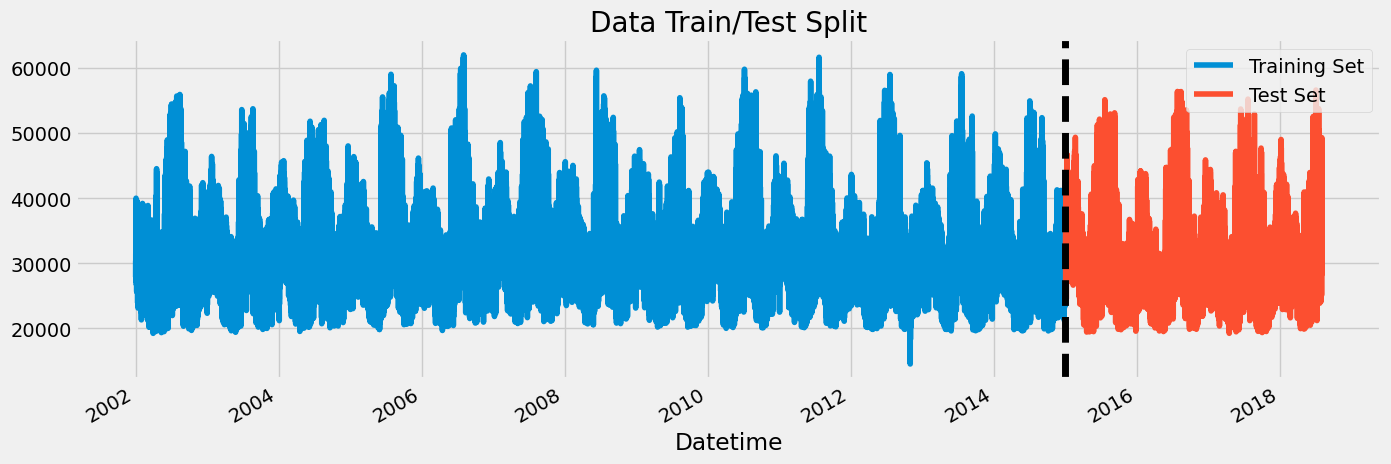

In [123]:
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# Let's visualize the data
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label = 'Test Set')
ax.axvline(x = test.index[0], color = 'k', linewidth = 5, ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

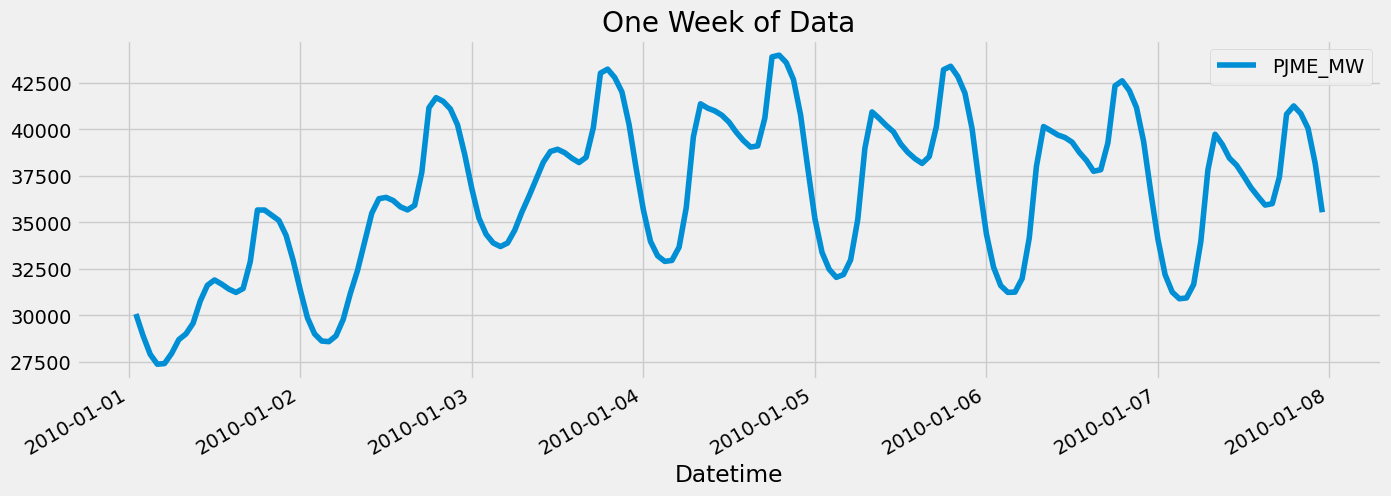

In [124]:
# Let's now visualize one week of data 
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='One Week of Data')
plt.show()

In each day there are two different peaks which is very common in energy consumption. There are valleys during the nights. 
Also we have a weekend effect here where one of these days actually January 1st is holiday 

# Feature Creation
We are going to create features as new columns in our dataset using pandas for days, hours...

In [125]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy() # We make a copy of the dataframe to avoid modifying the original dataframe
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday = 0, Sunday = 6, checked in pandas documentation
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month    
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship
One way to visualize our features vs target is by using seaborn box plots because they give you an idea of the distribution of the dataset.

[Text(0.5, 1.0, 'MX by Hour')]

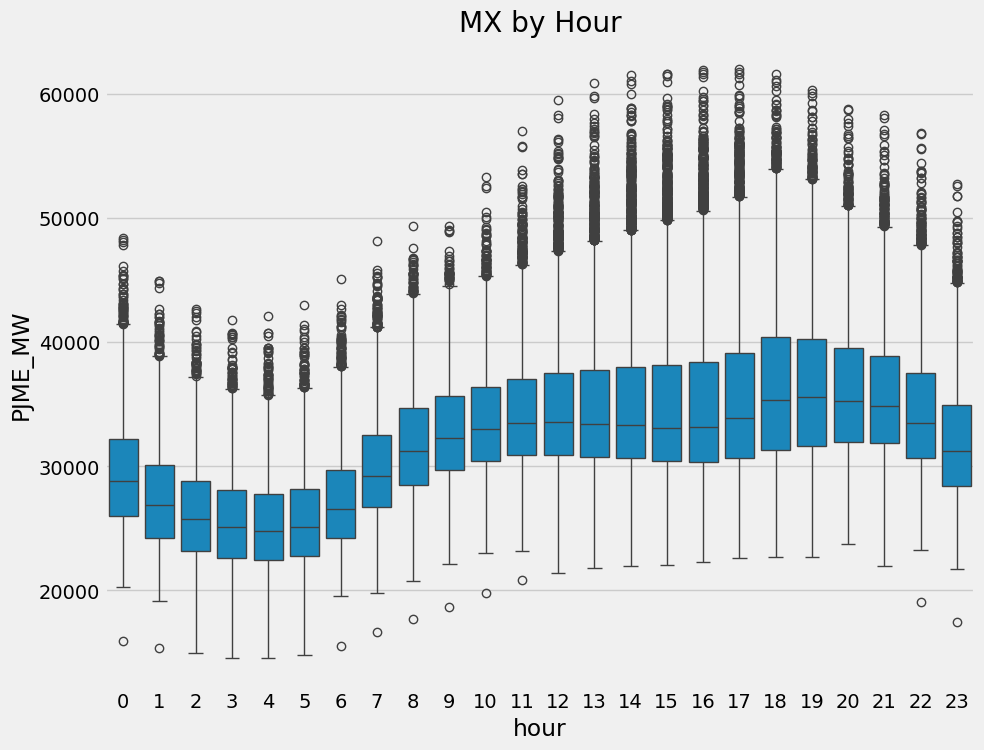

In [126]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set(title='MX by Hour')

[Text(0.5, 1.0, 'MX by Hour')]

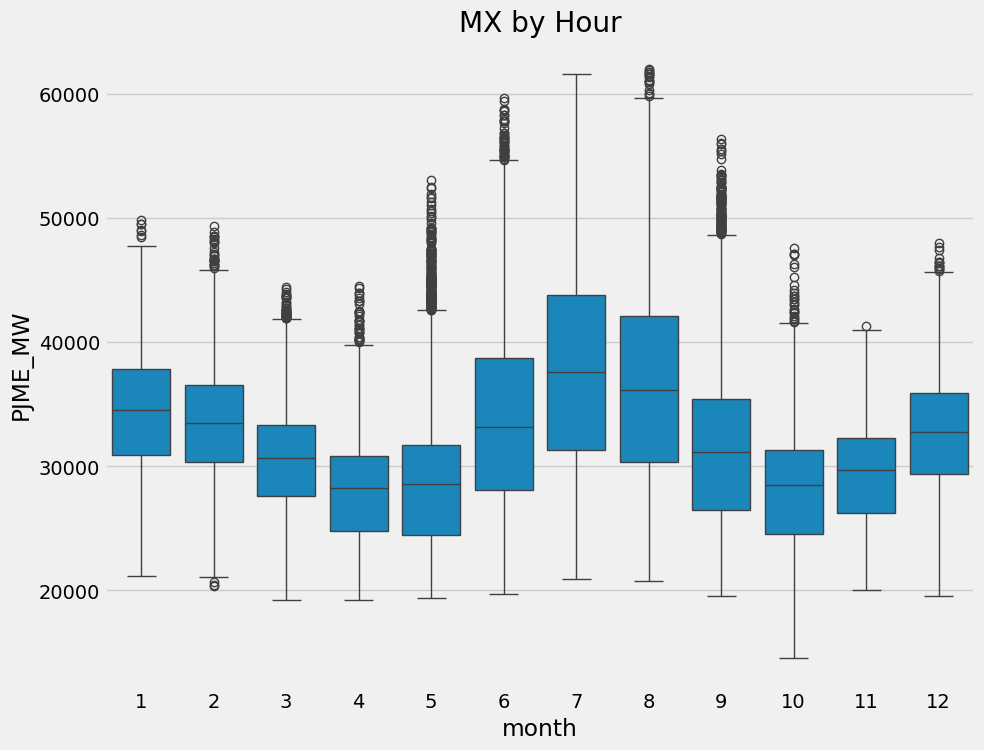

In [127]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set(title='MX by Hour')

As we see the MW usage by month tends to peak here two times in the winter season, in the fall and spring it has lower and another peak in the middle of summer when everyone uses their AC.

# Create our Model

In [128]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [129]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, # If the model does not improve after 50 rounds, we stop the training
                       learning_rate = 0.01) # We will use the XGBoost Regressor model, n_estimators is the number of trees we want to build
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], # We evaluate the model on the training and test set 
        verbose=100) # We want to see the output of the model only every 100 rounds


[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.83677
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.99037
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.46558


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

it stopped after 416 validations because our test validations set started to get worse after that many 
# Feature Importance

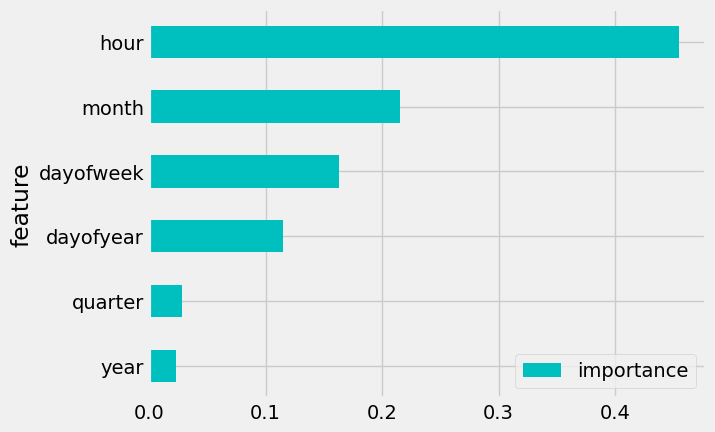

In [130]:
# We can see the importance of each feature in the xgboost model 
fi = pd.DataFrame({'feature': list(X_train.columns),
                     'importance': reg.feature_importances_})

fi.sort_values('importance').plot('feature', 'importance', kind='barh', color='c')
plt.show()

# Forecast on Test
Let's take our test data and make a new column called prediction where we will store the predictions

Because we would like to see these next to all of the training data let's merge this on the test set. Let's do how equals left and let's do left index is true and right index is true

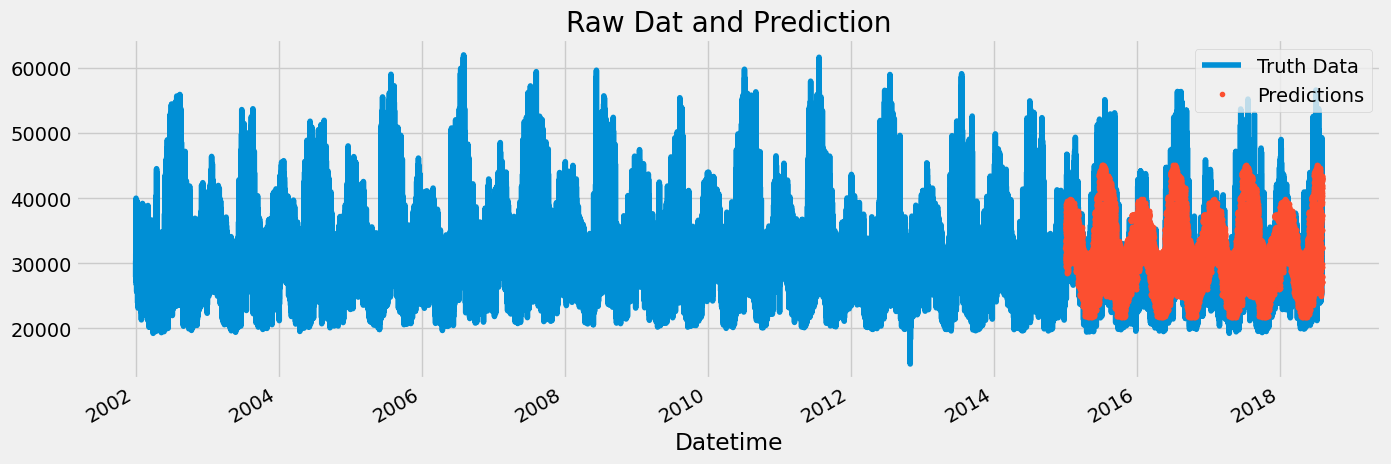

In [131]:
test['prediction'] = reg.predict(X_test) # We predict the test set using the model we trained
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True) # We merge the prediction with the original dataframe
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()                                           

Now let's take that week we analyzed before and plot it. Plotting the predictions and the ground truth over one week to see the model isn't perfect, there is a lot to improve like doing better parameter tuning, as the model was not tune at all. We could also add in features for specific days for the year like holidays.

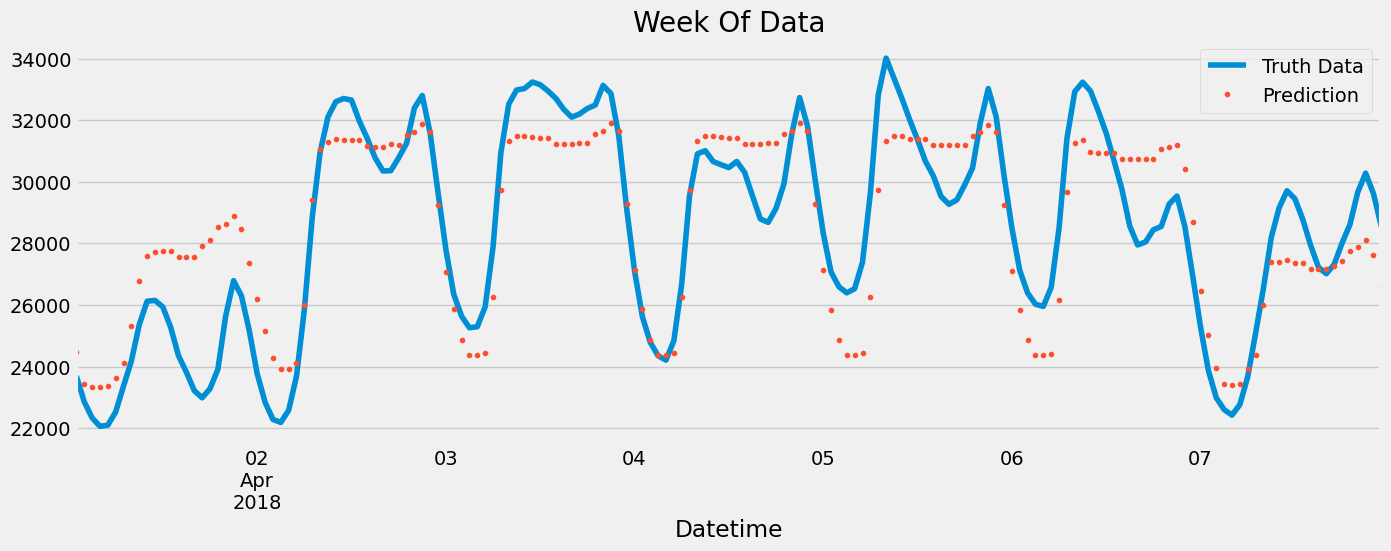

In [132]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [135]:
# actually the root mean squared error as we used in the previous example when evaluating the model
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE: {score:.2f}')

RMSE: 3741.16


# Calculate Error
Look at the worst and best predicted days

In [138]:
test['error'] = np.abs(test[TARGET] - test['prediction']) # take the absolute value of the difference between the truth and the prediction
test['date'] = test.index.date # We extract the date from the datetime index and store it in a new column
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5) # We group by the date and calculate the mean error

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

We can see the worst predicted days all seem to be in the middle of august of 2016. If we do the opposite we can see below that the best were made in 2016

In [139]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64